# Time series forecasting with GluonTS

The GluonTS toolkit contains components and tools for building time series models using MXNet. The models that are currently included are forecasting models but the components also support other time series use cases, such as classification or anomaly detection. 

The toolkit is not intended as a forecasting solution for businesses or end users but it rather targets scientists and engineers who want to tweak algorithms or build and experiment with their own models.  

GluonTS contains:
- Components for building new models (likelihoods, feature processing pipelines, calendar features etc.)
- Data loading and processing
- A number of pre-built models
- Plotting and evaluation facilities
- Artificial and real datasets (only external datasets with blessed license)

In [1]:
# Third-party imports
%matplotlib inline
import mxnet as mx
from mxnet import gluon
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

## Datasets

### GluonTS datasets

GluonTS comes with a number of publicly available datasets. 

In [2]:
from gluonts.dataset.repository.datasets import get_dataset, dataset_recipes
from gluonts.dataset.util import to_pandas

In [3]:
print(f"Available datasets: {list(dataset_recipes.keys())}")

Available datasets: ['m4_hourly', 'm4_daily', 'm4_weekly', 'm4_monthly', 'm4_quarterly', 'm4_yearly']


An available dataset can be easily downloaded by its name. In this notebook we will use the "m4_hourly" dataset that contains a few hundred time series. If the dataset already exists locally it is not downloaded again by setting `regenerate=False`.

In [4]:
dataset = get_dataset("m4_hourly", regenerate=False)

INFO:root:using dataset already processed in path m4_hourly.


In general, the datasets provided by GluonTS are objects that consists of three main components:
- `dataset.train` is an iterable collection of data entries used for training.
- `dataset.test` is an iterable collection of data entries used for inference. The test dataset is an extended version of the train dataset that contains a window in the end of each time series that was not seen during training. This window has length equal to the recommended prediction length.
- `dataset.metadata` containts metadata of the dataset such as the frequency of the time series, a recommended prediction horizon, associated features, etc. 

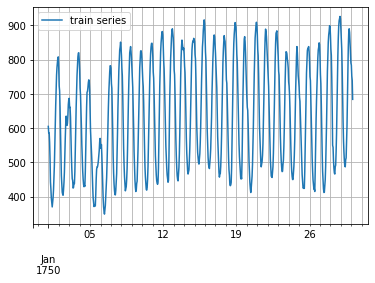

In [5]:
entry = next(iter(dataset.train))
train_series = to_pandas(entry)
train_series.plot()
plt.grid(which="both")
plt.legend(["train series"], loc="upper left")
plt.show()

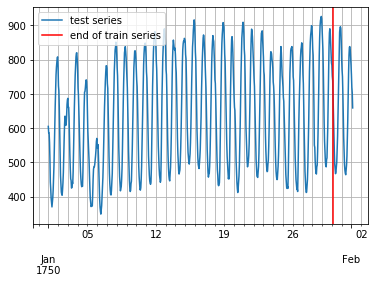

In [6]:
entry = next(iter(dataset.test))
test_series = to_pandas(entry)
test_series.plot()
plt.axvline(train_series.index[-1], color='r') # end of train dataset
plt.grid(which="both")
plt.legend(["test series", "end of train series"], loc="upper left")
plt.show()

In [7]:
print(f"Length of forecasting window in test dataset: {len(test_series) - len(train_series)}")
print(f"Recommended prediction horizon: {dataset.metadata.prediction_length}")
print(f"Frequency of the time series: {dataset.metadata.time_granularity}")

Length of forecasting window in test dataset: 48
Recommended prediction horizon: 48
Frequency of the time series: H


### Custom datasets

At this point, it is important to emphasize that GluonTS does not require this specific format for a custom dataset that a user may have. The only requirements for a custom dataset are to be iterable and have a "target" and a "start" field. To make this more clear, assume the common case where a dataset is in the form of a `numpy.array` and the index of the time series in a `pandas.Timestamp` (possibly different for each time series): 

In [8]:
N = 10  # number of time series
T = 100  # number of timesteps
prediction_length = 24
custom_dataset = np.random.normal(size=(N, T))
start = pd.Timestamp("01-01-2019", freq='1H')  # can be different for each time series

Now, you can split your dataset and bring it in a GluonTS appropriate format with just two lines of code:

In [9]:
# train dataset: cut the last window of length "prediction_length", add "target" and "start" fields
train_ds = [{'target': x, 'start': start} for x in custom_dataset[:, :-prediction_length]]
# test dataset: use the whole dataset, add "target" and "start" fields
test_ds = [{'target': x, 'start': start} for x in custom_dataset]

## Training an existing model (`Estimator`)

As we already mentioned, GluonTS comes with a number of pre-built models that can be used directly with minor hyperparameter configurations. For starters we will use one of these predefined models to go through the whole pipeline of training a model, predicting, and evaluating the results. 

GluonTS gives focus (but is not restricted) to probabilistic forecasting, i.e., forecasting the future distribution of the values and not the future values themselves (point estimates) of a time series. Having estimated the future distribution of each time step in the forecasting horizon, we can draw a sample from the distribution at each time step and thus create a "sample path" that can be seen as a possible realization of the future. In practice we draw multiple samples and create multiple sample paths which can be used for visualization, evaluation of the model, to derive statistics, etc.

In this example we will use a simple pre-built feedforward neural network estimator that takes as input a window of length `context_length` and predicts the distribution of the values of the subsequent future window of length `prediction_length`. 

In general, each estimator (pre-built or custom) is configured by a number of hyperparameters that can be either common (but not binding) among all estimators (e.g., the `prediction_length`) or specific for the particular estimator (e.g., number of layers for a neural network or the stride in a CNN).

Finally, each estimator is configured by a `Trainer`, which defines how the model will be trained i.e., the number of epochs, the learning rate, etc.  

In [10]:
from gluonts.model.simple_feedforward import SimpleFeedForwardEstimator
from gluonts.trainer import Trainer

In [11]:
estimator = SimpleFeedForwardEstimator(
    num_hidden_dimensions=[10],
    prediction_length=dataset.metadata.prediction_length,
    context_length=100,
    freq=dataset.metadata.time_granularity,
    trainer=Trainer(ctx="cpu", epochs=5, learning_rate=1E-3, hybridize=True, num_batches_per_epoch=200,),
)

After specifing our estimator with all the necessary hyperparameters we can train it using our training dataset `dataset.train` just by invoking the `train` method of the estimator. The training returns a predictor that can be used to predict.

In [12]:
predictor = estimator.train(dataset.train)

INFO:root:Start model training
INFO:root:Number of parameters in SimpleFeedForwardTrainingNetwork: 483
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 200/200 [00:01<00:00, 172.28it/s, avg_epoch_loss=5.2]
INFO:root:Epoch[0] Elapsed time 1.163 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=5.202276
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 200/200 [00:01<00:00, 171.91it/s, avg_epoch_loss=4.67]
INFO:root:Epoch[1] Elapsed time 1.165 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=4.666669
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 200/200 [00:01<00:00, 177.69it/s, avg_epoch_loss=4.67]
INFO:root:Epoch[2] Elapsed time 1.127 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=4.671061
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 200/200 [00:01<00:00, 177.48it/s, avg_epoch_loss=4.5]
INFO:root:Epoch[3] Elapsed time 1.128 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=4.504224
INFO:root:Epoch[4] Lear

Now we have a predictor in our hands. We can use it to predict the last window of the `dataset.test` and evaluate how our model performs.

GluonTS comes with the `make_evaluation_predictions` function that automates all this procedure. Roughly, this module performs the following steps:
- Removes the final window of length `prediction_length` of the `dataset.test` that we want to predict
- The estimator uses the remaining dataset to predict (in the form of sample paths) the "future" window that was just removed 
- The module outputs a generator over the forecasted sample paths and a generator over the `dataset.test` 

In [13]:
from gluonts.evaluation.backtest import make_evaluation_predictions

In [14]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset.test,  # test dataset
    predictor=predictor,  # predictor
    num_eval_samples=100,  # number of sample paths we want for evaluation
)

In [15]:
print(type(forecast_it))
print(type(ts_it))

<class 'generator'>
<class 'generator'>


First, we can convert these generators to lists to ease the subsequent computations.

In [16]:
forecasts = list(forecast_it)
tss = list(ts_it)

Now, let's see what do these lists contain under the hood. Let's start with the time series `tss` that is simpler. Each item in the `tss` list is just a pandas dataframe that contains the actual time series.

In [17]:
print(type(tss[0]))

<class 'pandas.core.frame.DataFrame'>


In [18]:
tss[0].head()  

,0
1750-01-01 00:00:00,605.0
1750-01-01 01:00:00,586.0
1750-01-01 02:00:00,586.0
1750-01-01 03:00:00,559.0
1750-01-01 04:00:00,511.0


The `forecasts` list is a bit more complex. Each item in the `forecasts` list is an object that contains all the sample paths in the form of `numpy.ndarray` with dimension `(num_samples, prediction_length)`, the start date of the forecast, the frequency of the time series, etc. We can access all these information by simply invoking the corresponding attribute of the forecast object.

In [22]:
print(type(forecasts[0]))

<class 'gluonts.model.forecast.SampleForecast'>


In [23]:
print(f"Number of sample paths: {forecasts[0].num_samples}")
print(f"Dimension of samples: {forecasts[0].samples.shape}")
print(f"Start date of the forecast window: {forecasts[0].start_date}")
print(f"Frequency of the time series: {forecasts[0].freq}")

Number of sample paths: 100
Dimension of samples: (100, 48)
Start date of the forecast window: 1750-01-30 04:00:00
Frequency of the time series: H


Apart from retrieving basic information we can do some more complex calculations such as to compute the mean or a given quantile of the values of the forecasted window.

In [24]:
print(f"Mean of the future window:\n {forecasts[0].mean}")
print(f"0.5-quantile (median) of the future window:\n {forecasts[0].quantile(0.5)}")

Mean of the future window:
 [629.5199  581.1798  495.5559  523.68604 472.27432 477.97052 521.7234
 475.29343 529.7915  573.77856 592.04    660.10046 763.43146 823.705
 847.7872  866.18    884.14484 853.5867  827.9777  855.0236  791.0335
 756.3753  739.8996  724.6091  619.0108  591.27795 525.08167 545.3986
 490.31552 483.52332 508.2323  501.3625  537.3705  580.55347 603.47736
 702.43695 729.0323  857.37476 885.73334 866.26166 830.4925  871.99274
 862.7176  838.7693  803.8697  738.5048  747.9125  707.5555 ]
0.5-quantile (median) of the future window:
 [628.6443  573.4246  489.42343 526.98096 463.10632 475.4459  505.4459
 470.03986 529.6933  573.5068  613.38184 658.4289  758.39746 817.4875
 840.7365  862.1159  894.1028  875.33685 850.5102  846.764   789.4258
 752.7204  737.11084 712.2827  597.7055  586.956   530.41907 538.1964
 500.46307 477.46765 507.92593 511.93475 520.7647  593.3009  619.8462
 704.4697  728.05646 846.58    906.80817 856.2603  842.3296  854.79553
 839.3267  830.1087  83

Finally, each forecast object has a `
plot` method that can be parametrized to show the mean, prediction intervals, etc. The prediction intervals are plotted in different shades so they are distinct. 

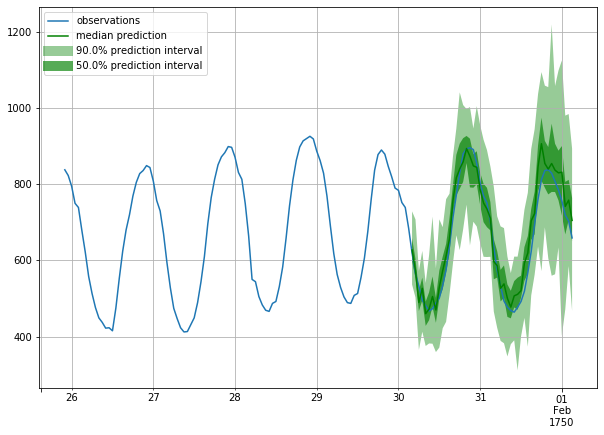

In [37]:
plot_length = 150 
prediction_intervals = (50.0, 90.0)
legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

fig, ax = plt.subplots(1, 1, figsize=(10, 7))
tss[0][-plot_length:].plot(ax=ax)  # plot the time series
forecasts[0].plot(prediction_intervals=prediction_intervals, color='g')
plt.grid(which="both")
plt.legend(legend, loc="upper left")
plt.show()

We can also evaluate the quality of our forecasts. GluonTS comes with an `Evaluator` that returns aggregate error metrics as well as metrics per time series which can be used e.g., for scatter plots.

In [38]:
from gluonts.evaluation import Evaluator

In [39]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(dataset.test))

Running evaluation: 100%|██████████| 414/414 [00:01<00:00, 268.14it/s]


In [40]:
print(json.dumps(agg_metrics, indent=4))

{
    "MSE": 6847822.17961192,
    "abs_error": 8610262.36520958,
    "abs_target_sum": 145558863.59960938,
    "abs_target_mean": 7324.822041043146,
    "seasonal_error": 336.9046924038305,
    "MASE": 2.6344021684899457,
    "sMAPE": 0.1661212386853806,
    "MSIS": 32.68499542064285,
    "QuantileLoss[0.1]": 4162731.5772917746,
    "Coverage[0.1]": 0.10723631239935587,
    "QuantileLoss[0.5]": 8610262.460141659,
    "Coverage[0.5]": 0.5480575684380032,
    "QuantileLoss[0.9]": 6364855.987939548,
    "Coverage[0.9]": 0.8796296296296297,
    "RMSE": 2616.834381387542,
    "NRMSE": 0.35725569395742923,
    "ND": 0.059153129890419716,
    "wQuantileLoss[0.1]": 0.02859826927985817,
    "wQuantileLoss[0.5]": 0.05915313054261002,
    "wQuantileLoss[0.9]": 0.04372702445278385,
    "mean_wQuantileLoss": 0.04382614142508401,
    "MAE_Coverage": 0.02522141706924316
}


In [42]:
item_metrics.head()

,Coverage[0.1],Coverage[0.5],Coverage[0.9],MASE,MSE,MSIS,QuantileLoss[0.1],QuantileLoss[0.5],QuantileLoss[0.9],abs_error,abs_target_mean,abs_target_sum,item_id,sMAPE,seasonal_error
0,0.000000,0.750000,1.000000,0.753910,1507.386882,4.952252,800.121735,1533.319214,1214.278711,1533.319214,659.250000,31644.0,NaN,0.049228,42.371302
1,0.395833,1.000000,1.000000,2.122012,142951.479167,14.783557,4668.051855,16817.332275,7753.696387,16817.332031,2586.437500,124149.0,NaN,0.134143,165.107988
2,0.000000,0.208333,0.833333,1.519555,28822.294271,11.364326,3090.635510,5754.059387,2064.791077,5754.059570,1354.791667,65030.0,NaN,0.083350,78.889053
3,0.041667,0.500000,0.937500,1.382062,214285.500000,7.576593,8223.216943,17180.613770,6969.510547,17180.613281,4912.145833,235783.0,NaN,0.070529,258.982249
4,0.041667,0.812500,1.000000,1.205638,88569.635417,5.509598,3120.685864,11602.712769,6840.998047,11602.712891,2731.000000,131088.0,NaN,0.080723,200.494083


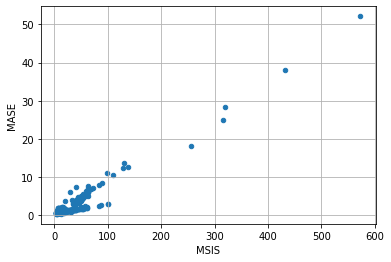

In [53]:
item_metrics.plot(x='MSIS', y='MASE', kind='scatter')
plt.grid(which="both")
plt.show()

## Create your own forecast model

For creating your own forecast model you need to:
- Define the training and prediction network
- Define a new estimator that specifies any data processing and uses the networks

The training and prediction networks can be arbitrarily complex but they should follow some basic rules:
- Both should have a `hybrid_forward` method that defines what should happen when the network is called    
- The trainng network's `hybrid_forward` should return a **loss** based on the prediction and the true values
- The prediction network's `hybrid_forward` should return the predictions 

For example, we can create a simple training network that defines a neural network which takes as an input the past values of the time series and outputs a future predicted window of length `prediction_length`. It uses the L1 loss in the `hybrid_forward` method to evaluate the error among the predictions and the true values of the time series. The corresponding prediction network should be identical to the training network in terms of architecture (we achieve this by inheriting the training network class), and its `hybrid_forward` method outputs directly the predictions.

Note that this simple model does only point forecasts by construction, i.e., we train it to outputs directly the future values of the time series and not any probabilistic view of the future (to achieve this we should train a network to learn a probability distribution and then sample from it to create sample paths).

In [55]:
class MyTrainNetwork(gluon.HybridBlock):
    def __init__(self, prediction_length, **kwargs):
        super().__init__(**kwargs)
        self.prediction_length = prediction_length
    
        with self.name_scope():
            # Set up a 3 layer neural network that directly predicts the target values
            self.nn = mx.gluon.nn.HybridSequential()
            self.nn.add(mx.gluon.nn.Dense(units=40, activation='relu'))
            self.nn.add(mx.gluon.nn.Dense(units=40, activation='relu'))
            self.nn.add(mx.gluon.nn.Dense(units=self.prediction_length, activation='softrelu'))

    def hybrid_forward(self, F, past_target, future_target):
        prediction = self.nn(past_target)
        # calculate L1 loss with the future_target to learn the median
        return (prediction - future_target).abs().mean(axis=-1)


class MyPredNetwork(MyTrainNetwork):
    # The prediction network only receives past_target and returns predictions
    def hybrid_forward(self, F, past_target):
        prediction = self.nn(past_target)
        return prediction.expand_dims(axis=1)

Now, we need to construct the estimator which should also follow some rules:
- It should include a `create_transformation` method that defines all the possible feature transformations and how the data is split during training
- It should include a `create_training_network` method that returns the training network configured with any necessary hyperparameters
- It should include a `create_predictor` method that creates the prediction network, and returns a `Predictor` object 

A `Predictor` defines the `predict` method of a given predictor. Roughly, this method takes the test dataset, it passes it through the prediction network and yields the predictions. You can think of the `Predictor` object as a wrapper of the prediction network that defines its `predict` method. 

Earlier, we used the `make_evaluation_predictions` to evaluate our predictor. Internally, the `make_evaluation_predictions` function invokes the `predict` method of the predictor to get the forecasts.

In [56]:
from gluonts.model.estimator import GluonEstimator
from gluonts.model.predictor import Predictor, RepresentableBlockPredictor
from gluonts.core.component import validated
from gluonts.support.util import copy_parameters
from gluonts.transform import ExpectedNumInstanceSampler, Transformation, InstanceSplitter, FieldName
from mxnet.gluon import HybridBlock

In [57]:
class MyEstimator(GluonEstimator):
    @validated()
    def __init__(
        self,
        freq: str,
        context_length: int,
        prediction_length: int,
        trainer: Trainer = Trainer()
    ) -> None:
        super().__init__(trainer=trainer)
        self.context_length = context_length
        self.prediction_length = prediction_length
        self.freq = freq
        
    
    def create_transformation(self):
        # Feature transformation that the model uses for input. 
        # Here we use a transformation that randomly select training samples from all time series.
        return InstanceSplitter(
                    target_field=FieldName.TARGET,
                    is_pad_field=FieldName.IS_PAD,
                    start_field=FieldName.START,
                    forecast_start_field=FieldName.FORECAST_START,
                    train_sampler=ExpectedNumInstanceSampler(num_instances=1),
                    past_length=self.context_length,
                    future_length=self.prediction_length,
                )
    
    def create_training_network(self) -> MyTrainNetwork:
        return MyTrainNetwork(
            prediction_length=self.prediction_length
        )

    def create_predictor(
        self, transformation: Transformation, trained_network: HybridBlock
    ) -> Predictor:
        prediction_network = MyPredNetwork(
            prediction_length=self.prediction_length
        )

        copy_parameters(trained_network, prediction_network)

        return RepresentableBlockPredictor(
            input_transform=transformation,
            prediction_net=prediction_network,
            batch_size=self.trainer.batch_size,
            freq=self.freq,
            prediction_length=self.prediction_length,
            ctx=self.trainer.ctx,
        )

Now, we can repeat the same pipeline as in the case we had a pre-built model: train the predictor, create the forecasts and evaluate the results.

In [58]:
estimator = MyEstimator(
    prediction_length=dataset.metadata.prediction_length,
    context_length=200,
    freq=dataset.metadata.time_granularity,
    trainer=Trainer(ctx="cpu", epochs=5, learning_rate=1E-3, hybridize=True, num_batches_per_epoch=200,),
)

In [59]:
predictor = estimator.train(dataset.train)

INFO:root:Start model training
INFO:root:Number of parameters in MyTrainNetwork: 128
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 200/200 [00:00<00:00, 223.19it/s, avg_epoch_loss=1.99e+03]
INFO:root:Epoch[0] Elapsed time 0.898 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=1993.152545
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 200/200 [00:00<00:00, 217.75it/s, avg_epoch_loss=734]
INFO:root:Epoch[1] Elapsed time 0.920 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=734.173925
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 200/200 [00:00<00:00, 217.44it/s, avg_epoch_loss=610]
INFO:root:Epoch[2] Elapsed time 0.921 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=610.446665
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 200/200 [00:00<00:00, 218.56it/s, avg_epoch_loss=626]
INFO:root:Epoch[3] Elapsed time 0.916 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=626.432888
INFO:root:Epoch[4] Learning r

In [60]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset.test, 
    predictor=predictor, 
    num_eval_samples=100
)

In [61]:
forecasts = list(forecast_it)
tss = list(ts_it)

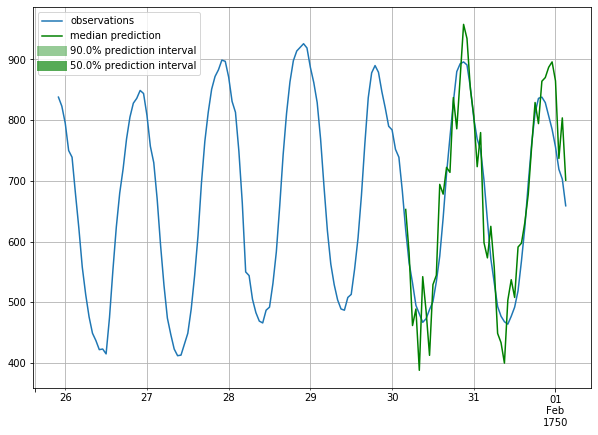

In [62]:
plot_length = 150 
prediction_intervals = (50.0, 90.0)
legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

fig, ax = plt.subplots(1, 1, figsize=(10, 7))
tss[0][-plot_length:].plot(ax=ax)  # plot the time series
forecasts[0].plot(prediction_intervals=prediction_intervals, color='g')
plt.grid(which="both")
plt.legend(legend, loc="upper left")
plt.show()

We observe from the plot above that we cannot actually see any prediction intervals in the predictions. This is expected since the model that we defined does not do probabilistic forecasting but it just gives point estimates. By requiring 100 sample paths (defined in `make_evaluation_predictions`) in such a network, we get 100 times the same output.

In [ ]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(dataset.test))

In [ ]:
print(json.dumps(agg_metrics, indent=4))

In [ ]:
item_metrics.head(10)

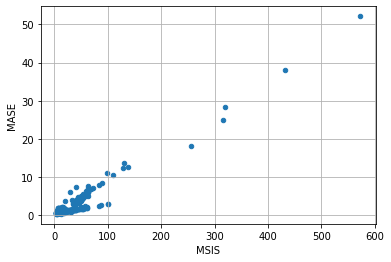

In [54]:
item_metrics.plot(x='MSIS', y='MASE', kind='scatter')
plt.grid(which="both")
plt.show()